---
title:  "✅ Week 09 - Student Solutions"
subtitle: Introduction to anomaly detection in Python
author: "MY NAME (MY CANDIDATE NUMBER)"
date: 17 March 2025
---

Let's start by loading the relevant libraries!

In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.metrics import calinski_harabasz_score
from kneed import KneeLocator
from yellowbrick.cluster import KElbowVisualizer
from lets_plot import *
LetsPlot.setup_html()

# Introducing a new data set (10 minutes)

In this lab, we will use outlier detection to deepen our appreciation of 2000s and 2010s pop music. Using data from Spotify, we have a list of features for 919 popular singles that were released in the 1990s.  Features include:

-   `artist`: Name of the Artist.
-   `song`: Name of the Track.
-   `duration_ms`: Duration of the track in milliseconds.
-   `explicit`: The lyrics or content of a song or a music video contain one or more of the criteria which could be considered offensive or unsuitable for children.
-   `year`: Release Year of the track.
-   `popularity`: The higher the value the more popular the song is.
-   `danceability`: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall -   regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
-   `energy`: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity.
-   `key`: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
-   `loudness`: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
-   `mode`: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
-   `speechiness`: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
-   `acousticness`: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
-   `instrumentalness`: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
-   `liveness`: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
-   `tempo`: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
-   `genre`: Genre of the track.

In [31]:
# Load the data set
hits = pd.read_csv("../data/2000s-hits-data.csv")

# Print the shape attribute 
print(hits.shape)

(2000, 18)


### 🗣CLASSROOM DISCUSSION

(Your class teacher will mediate this discussion)

-   How would you explore this data if dimensionality reduction was not an option?

*Scatter plots for relationships between two continuous features. Box plots to assess relationships between continuous features over categorical features.*

-   How would you answer: what are the **most common types of songs** one can find on this data set?

*We could try k-means clustering and look at key quantities of interest such as the centroids of those clusters over a range of different features.*

# Principle component analysis (20 minutes)

Let's create a list of different musical attributes, and filter the data frame to only include said attributes:

In [32]:
# Create a list of musical attributes
music_attrs = ["danceability","energy","loudness","speechiness","acousticness","instrumentalness","liveness","valence"]

# Create a new filtered data frame
hits_attrs = hits.filter(items=music_attrs)

### 🎯 ACTION POINTS

1.  To try to make sense of the sheer number of combinations of attributes, we will run PCA and apply it to our data set:

In [33]:
# Create a pipeline that scales the data and performs a PCA (select the first 5 components)
pipe = Pipeline([("scaler",StandardScaler()), ("pca",PCA(n_components=5))])

# Call the fit_transform method on the filtered data frame
components = pipe.fit_transform(hits_attrs)

2.  How much 'information' are we keeping after compressing the data with PCA?

*If we take the first 5 principle components, we can explain over 81% of the variance among our features*

In [34]:
# Create a data frame with a range of principle components and the cumulative variance
variance_explained = pd.DataFrame({"component":range(1,6), "variance":np.cumsum(pipe.named_steps["pca"].explained_variance_ratio_)})

# Plot the output
(
    ggplot(variance_explained, aes("component","variance")) +
    geom_bar(stat="identity") +
    theme(panel_grid_major_x=element_blank()) +
    labs(x = "Principle Component", y = "Cumulative variance",
         title = "The first 5 principle components explain ~81% of the variation amongst\nour features!")
)

3.  Let's focus on the first two components, as they are common plotting practices.

Think of the plot below as a \~45% compressed 2D representation of our 8 musical attributes.

In [37]:
# Create a data frame of the components
output_df = pd.DataFrame(components, columns=[f"PC{i+1}" for i in range(5)])

# Add information on artist and track to the data frame
output_df = pd.concat([output_df, hits[["song","artist"]]], axis=1)

# Plot the output, using tooltips to convey what artist / track is being hovered over
(
    ggplot(output_df, aes("PC1", "PC2")) +
    geom_point(alpha = 0.5, tooltips = layer_tooltips().line("@artist").line("@song"))
)

### 🧑‍🏫 TEACHING MOMENT

Your class teacher will now guide the conversation and explain the plot below. If needed, they will recap how PCA works.

In [36]:
# Create a list of data frames for each loading
list_dfs = [pd.DataFrame({"features":hits_attrs.columns,"loadings":comp}) for comp in pipe.named_steps["pca"].components_]

# Concatenate the list of data frames to create a singular data frame
loadings_df = pd.concat(list_dfs, keys = [i + 1 for i in range(5)], names = ["component","row"]).\
    reset_index().\
        drop(columns=["row"],index=1)

# Create a new column showing the absolute value of the loading
loadings_df["abs_loadings"] = np.abs(loadings_df["loadings"])

# Plot the output
(
    ggplot(loadings_df.query("component <= 4"), aes("loadings","features", fill = "abs_loadings")) +
    geom_bar(stat="identity", tooltips = layer_tooltips().line("PC@component - @features: @abs_loadings")) +
    facet_wrap(facets="component") +
    scale_fill_viridis() +
    theme(legend_position = "none") +
    labs(x = "Loadings", y = "Features")
)

🗣️ **Discussion**:

-   How does Figure 3 help you interpret Figure 2?

*We can see precisely which variables ended up contributing to each principle component.*

-   How does the above help you think about the attributes of the **most common type** of songs?

*We can look at PC01 (the principle component that explains the largest variance among features), which shows songs with high valence, low acousticness and high loudness.*

## Part III: Anomaly detection techniques (1 hour)

👥 IN PAIRS, go through the action points below and discuss your impressions and key takeaways.

🎯 **ACTION POINTS**

1.  Take a look at the clusters identified by DBSCAN! We will employ a method that can help you determine values for the epsilon neighbourhood and minimum samples hyperparameters.  We adapted this code from [here](https://towardsdatascience.com/k-means-dbscan-gmm-agglomerative-clustering-mastering-the-popular-models-in-a-segmentation-c891a3818e29/).

In [38]:
# Set min_samples equal to 2 times the number of dimensions
min_samples = 4

# Instantiate nearest neighbours model, setting n_neighbors equal to min_sample
nearest_neighbors = NearestNeighbors(n_neighbors=min_samples)

# Fit the model to the first two principle components
neighbors = nearest_neighbors.fit(output_df[["PC1","PC2"]])

# Extract the distances and indices from the nearest neighbours model
distances, indices = neighbors.kneighbors(output_df[["PC1","PC2"]])

# Sort the distances from the 4th dimension of the distances matrix
distances = np.sort(distances[:,min_samples-1], axis=0)

In [39]:
# Identify the knee point
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
eps = distances[knee.knee]
print(f"We should set the epsilon neighbourhood value to ~ {np.round(eps,4)}!")

We should set the epsilon neighbourhood value to ~ 0.2129!


In [40]:
# Instantiate a DBSCAN model
dbscan = DBSCAN(eps = eps, min_samples = min_samples)

# Fit the model to the first two principle component features
_ = dbscan.fit(output_df[["PC1","PC2"]])

In [41]:
# Plot the output

to_plot = output_df
to_plot["dbscan"] = [str(lab) for lab in dbscan.labels_]
to_plot["dbscan_outlier"] = np.where(to_plot["dbscan"] == "-1", "Yes", "No")

(
    ggplot(to_plot, aes("PC1", "PC2", color = "dbscan_outlier")) +
    geom_point(tooltips = layer_tooltips().line("@song").line("@artist")) +
    labs(color = "Outlier")
)


🗣 **Discussion**: How well do you think DBSCAN performs at anomaly detection on the two principle components?

*It is pretty good, and we can visually perceive that. The algorithm is able to identify clear 'outliers' in the data. Just remember that we are looking at just the two first principal components, and these two PCs don't encode all the variables in the data the same way.*

*Based on the selected values of the hyperparameters (which we selected with the k-distance graph heuristic^[to apply the k-distance graph heuristic, you first calculate the distance between the nearest points for each value, setting the k-nearest neighbours equal to the minimum number of points. You then rank these values by distance and find the "knee" in the plot, which corresponds roughly to the optimal epsilon neighbourhood value]), we can see that DBSCAN has identified 2000 outliers that can be considered reasonable candidates.*

*Unfortunately, the k-distance plot method is just that: a heuristic, which means it's not fool-proof. You'd have to examine the plot in more details to check if the outliers found really make sense...*

🎯 **ACTION POINTS**

2.  Take a look at the clusters identified by k-means:

We have included a different cluster evaluation metric to the Elbow method - the Calinski-Harabasz Score.  Basically, the top CH score is meant to produce the optimal number of clusters.

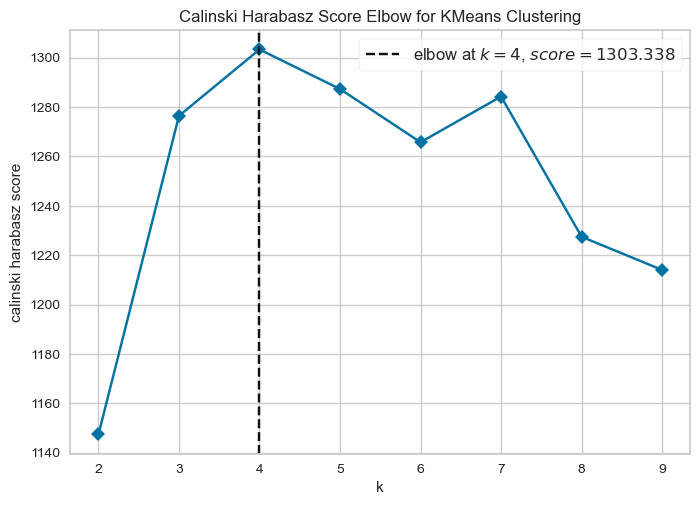

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [23]:
# Instantiate a k-means model
model = KMeans(random_state=42)

# Instantiate a visualizer from the yellowbrick library
visualizer = KElbowVisualizer(model, k=(2,10), metric = "calinski_harabasz", timings=False)

# Fit the visualizer to the first two principle components
visualizer.fit(output_df[["PC1","PC2"]])

# Finalize and render the figure
visualizer.show() 

In [24]:
# Instantiate a model
kmeans = KMeans(n_clusters=4)

# Fit the model to the data
_ = kmeans.fit(output_df[["PC1","PC2"]])

# Create a data frame based on customers by adding the cluster labels
to_plot["kmeans"] = [str(i) for i in kmeans.labels_]

(
  ggplot(to_plot, aes("PC1", "PC2", colour = "kmeans")) +
  geom_point(tooltips = layer_tooltips().line("@song").line("@artist").line("Cluster @kmeans")) +
  theme_minimal() +
  theme(panel_grid_minor = element_blank(),
        legend_position = "bottom") +
  labs(x = "PC1", y = "PC2",
       colour = "Cluster #")
)


🗣 **Discussion**: How well do you think k-means performs at anomaly detection on the two principle components?

*Not particularly well.  The k-means algorithm partitions the feature space into 4 different chunks, whereas we want to identify outliers, a.k.a. points that exist outside the main "blob".*

🎯 **ACTION POINTS**

3.  Take a look at the clusters identified by the isolation forest:

In [26]:
# Instantiate a model
pipe = Pipeline([("scaler", StandardScaler()), ("isoforest", IsolationForest(random_state=123))])

# Fit model to training data
pipe.fit(output_df[["PC1","PC2"]])

# Calculate the anomaly scores for the same data frame
to_plot["isoforest"] = pipe.score_samples(output_df[["PC1","PC2"]])

# Thresholds to try out
iso_ths = [-0.7, -0.65, -0.6, -0.55]

# Create variables that exceed each threshold
for th in iso_ths:
    to_plot[f"iso_th_{th}"] = to_plot["isoforest"] <= th

# Keep only the track, artist, first two principle components and various isoforest threshold variables
feats_to_keep = to_plot.columns[to_plot.columns.str.contains("song|artist|PC[1-2]|iso_th")]

# Create a melted data frame to plot
to_plot_melted = (
    to_plot
    .filter(items = feats_to_keep)
    .melt(id_vars = feats_to_keep[feats_to_keep.str.contains("song|artist|PC")])
    .rename(columns = {"variable":"th", "value": "isoforest_outlier"})
    .assign(th = lambda x: x["th"].str.replace("iso_th_","Threshold = "))
 
 )

# Plot the outliers
(
    ggplot(to_plot_melted, aes("PC1","PC2",color="isoforest_outlier")) +
    geom_point(tooltips = layer_tooltips().line("@song").line("@artist")) +
    facet_wrap(facets = "th") +
    labs(color = "Outlier?")
)

🗣 **Discussion**: What is the relationship between the anomaly score and the number of outliers in the data?

*As the anomaly score decreases, the number of outliers designated by the isolation forest will decrease.*

🎯 **ACTION POINTS**

4.  Let's see if the Local Outlier Factor (LOF) performs better than DBSCAN/Isolation Forest.

We use the `LocalOutlierFactor()` function to calculate local outlier factors:

In [27]:
# Instantiate a Local Outlier Factor model, setting nearest neighbors to 10
lof = LocalOutlierFactor(n_neighbors = 10)

# Fit the model to the first two principle components
lof.fit(output_df[["PC1","PC2"]])

# Append the negative outlier factor score to the data frame, using absolute values
to_plot["lof"] = np.abs(lof.negative_outlier_factor_)

In [29]:
# Plot the output, using size to distinguish between LOF scores

ggplot(to_plot, aes(x="PC1", y="PC2", size="lof", color="lof")) + \
    geom_point(tooltips=layer_tooltips().line("@song").line("@artist").line("LOF: @lof"),
               alpha=0.5) + \
    theme(legend_position="right") + \
    scale_color_viridis() + \
    labs(color="LOF score", 
         caption="\nNote: larger, lighter dots indicate higher LOF scores!") + \
    guides(size="none")  # Hides the size legend

🗣 **Discussion**: Does LOF perform better than DBSCAN or isolation forests to detect 'anomalous' samples?

*This is maybe a bit of a trick question. Instead of thinking about anomalies in a global sense, the LOF looks at outliers by taking distinct areas of the graph and calculating outlier scores from that vantage point. DBSCAN and isolation forests (when properly tuned) by contrast look at global outliers.*

*LOF provides a different, complementary picture of the data. It doesn't single out outliers but shows you how a particular sample is an outlier of its neighbourhood.*